# Logistic Regression Tumor/normal Feature Selection
identify genes that maximal activate and compare to know cancer causing genes

In [1]:
import keras
print("keras version should be Keras==2.1.6, new version can not save and restore models")
print("keras version:{}".format(keras.__version__))
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sys

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

Using TensorFlow backend.


keras version should be Keras==2.1.6, new version can not save and restore models
keras version:2.1.6


In [2]:
# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)
from loadData import loadTumorNormalData

/home/ubuntu/BME-230a


In [3]:
# save this code example 

# do not use google drive it is really slow
# load data from AWS EBS volumne: BME-230a-project volume id: vol-026c8e33988a1475b

# from google.colab import drive
# drive.mount('/content/drive') # force_remount=True
# projectDirUnix="drive/'My Drive'/GD_BME230a/project"
# projectDir="drive/My Drive/GD_BME230a/project"
# !ls $projectDirUnix

# rootDir = "/bme-230a-ebs"
# dataFile = "{}/data/tcga_target_gtex.h5".format(rootDir)
# store = pd.HDFStore(dataFile, mode="r")
# print("store.info():{}".format(store.info()))
# print("store.keys():{}".format(store.keys()))

In [4]:
%%time

rootDir = "/bme-230a-ebs"
XTrainDF, yTrainSeries, _, _ = loadTumorNormalData(rootDir)
yTrainDF = pd.DataFrame(yTrainSeries)
yTrainSeries = None # clean up memory

sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.35 s, sys: 5.64 s, total: 6.99 s
Wall time: 47.2 s


In [5]:
print("XTrainDF.shape:{}".format(XTrainDF.shape))
XTrainDF.iloc[0:3,0:3]

XTrainDF.shape:(15300, 58581)


,5S_rRNA,5_8S_rRNA,7SK
0,-9.966041,-9.965816,-0.687321
1,-9.966041,-9.965816,-9.965881
2,-9.966041,-9.965816,-9.965881


# Load trained model

In [6]:
%%time
# load model
from keras.models import load_model
modelName="logisticRegressionTumorNormal"
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/full{}.h5".format(modelRootDir, modelName)
print("fullModelPath:{}".format(fullModelPath))

model = load_model(fullModelPath)
model.summary()
#model.get_weights()
print("model.optimizer:{}".format(model.optimizer))

fullModelPath:/bme-230a-ebs/models/fulllogisticRegressionTumorNormal.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 58582     
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 292,906
Trainable params: 175,744
Non-trainable params: 117,162
_________________________________________________________________
model.optimizer:<keras.optimizers.Adam object at 0x7f7e71c68d30>
CPU times: user 684 ms, sys: 4 ms, total: 688 ms
Wall time: 689 ms


# start eval

In [7]:
%%time
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
# We want to identify how much each feature contributes to Z the value passed to the activation layer
# its important that we use the batch_normalization layer from our logistic regression model
# else we will potentially scale the data to a distribution with a different mean and variance

from keras.models import Model

layerName="batch_normalization_1"
normalizationModel = Model(inputs=model.input,
                                 outputs=model.get_layer(layerName).output)

normalizedXTrain = normalizationModel.predict(XTrainDF)

print("normalizedXTrain.shape:{}".format(XTrainDF.shape))
print("type(normalizedXTrain):{}".format(type(normalizedXTrain)))

normalizedXTrain.shape:(15300, 58581)
type(normalizedXTrain):<class 'numpy.ndarray'>
CPU times: user 19.8 s, sys: 852 ms, total: 20.6 s
Wall time: 6.54 s


In [8]:
# make sure batch normalization was applied
print(XTrainDF.iloc[0:5,0:5])
print()
print(normalizedXTrain[0:5,0:5])

    5S_rRNA  5_8S_rRNA       7SK    A1BG  A1BG-AS1
0 -9.966041  -9.965816 -0.687321  2.7487    0.6425
1 -9.966041  -9.965816 -9.965881  1.7489    0.4552
2 -9.966041  -9.965816 -9.965881  3.1393   -0.5332
3 -9.966041  -9.965816 -9.965881  1.8957    0.3346
4 -9.966041  -9.965816 -9.965881  6.1639    2.7951

[[-0.22909236 -0.01842499  1.7634513  -0.4423349  -0.33213907]
 [-0.22909236 -0.01842499 -0.59044564 -0.93999165 -0.45341104]
 [-0.22909236 -0.01842499 -0.59044564 -0.24791121 -1.0933752 ]
 [-0.22909236 -0.01842499 -0.59044564 -0.86692107 -0.5314965 ]
 [-0.22909236 -0.01842499 -0.59044564  1.2576027   1.0616152 ]]


In [9]:
%%time
# create a new dataFrame that combines our features with out labels
# the index for XTrainDF are integers
# teh index for yTrainDF GTEX values e.g. GTEX-ZQG8-2426-SM-57WEE
normalizedXTrainDF = pd.DataFrame(normalizedXTrain, columns=XTrainDF.columns)
evalTrainDF = pd.concat([normalizedXTrainDF, yTrainDF.reset_index(drop=True)], axis=1)
yTrainDF = None # clean up memory
normalizedXTrainDF = None # clean up memory
XTrainDF = None # clean up memory

CPU times: user 2.25 s, sys: 652 ms, total: 2.9 s
Wall time: 2.9 s


In [10]:
def calcStats(df, categoryColName, listOfAggFunctions):
    '''
    # https://stackoverflow.com/a/14734627/4586180
    1. groups rows by category
    2. applies the aggregate function to each group
    
    arguments:
        df:
            dataframe
            
        categoryColName:
            a string identifying the column to group by
            
        listOfAggFunctions:
            a list of string names of the aggrate function to run
    
    returns
        a dictionary. 
            The key will be the classes in the col identifyied by categoryColName
            the value will be a dataframe with the aggragate values
        
    '''
    ret = dict()
    grouped = df.groupby(categoryColName)
    for key, group in grouped:
        stats = group.agg(listOfAggFunctions)
        ret[key] = stats
        
    return ret
        
   
# small example that explains what it calcStats() does
tn = pd.Series(["normal","tumor","normal","tumor"], dtype="category")
df = pd.DataFrame({"gene1":[1,2,3,4],
                   "gene2":[11, 22, 33, 44],
                   "tumorNormal":tn})

ret = calcStats(df=df, categoryColName="tumorNormal", listOfAggFunctions=['min', 'max', 'mean'])
print()
for key in ret.keys():
    print("key:{}\n{}\n".format(key, ret[key]))


key:normal
      gene1  gene2
min     1.0   11.0
max     3.0   33.0
mean    2.0   22.0

key:tumor
      gene1  gene2
min     2.0   22.0
max     4.0   44.0
mean    3.0   33.0



In [11]:
%%time
# for each class, calculate the mean value for each gene
statsTrainDict = calcStats(df=evalTrainDF, categoryColName="tumor_normal_value", 
                      listOfAggFunctions=['min', 'max', 'std', 'mean'])
evalTrainDF = None # clean up memory

CPU times: user 1min 12s, sys: 976 ms, total: 1min 13s
Wall time: 1min 13s


In [12]:
# the keys are '0' and '1'
# AEDWIP make sure '0' is normal
normalTrainDF = statsTrainDict[0]
tumorTrainDF = statsTrainDict[1]
print("normalTrainDF.shape:{}".format(normalTrainDF.shape))
print(" tumorTrainDF.shape:{}".format(tumorTrainDF.shape))
statsTrainDict = None # clean up memory

normalTrainDF.shape:(4, 58582)
 tumorTrainDF.shape:(4, 58582)


In [13]:
print(normalTrainDF.iloc[0:4, 0:3])
last3ColLabels = normalTrainDF.columns[-3:]
print()
print(normalTrainDF.iloc[0:4,:].loc[:,last3ColLabels])

       5S_rRNA  5_8S_rRNA       7SK
min  -0.229092  -0.018425 -0.590446
max   5.554689  68.263947  2.793195
std   1.095426   0.823410  1.058365
mean  0.045851  -0.008494  0.078725

        uc_338  yR211F11.2  tumor_normal_value
min  -2.405998   -0.343928                 0.0
max   1.359166    4.647242                 0.0
std   0.827414    0.876714                 0.0
mean  0.305524   -0.090991                 0.0


In [14]:
# identify which gene have the greatest effect on z
# by multiplying the means by the dense layer weight
denseLayer = model.get_layer('dense_1')
#print(denseLayer.get_config())
weights = denseLayer.get_weights()
# print("len(weights):{}".format(len(weights)))
# print("weights[0][0:3]:{}".format(weights[0][0:3]))
# print("len(weights[0]):{}".format(len(weights[0])))
# print("len(weights[1]):{}".format(len(weights[1])))

# weights[1] is the bias term
coeficients = weights[0]
print("coeficients.shape:{}".format(coeficients.shape))

coeficients.shape:(58581, 1)


aedwp

In [15]:
# select all the gene col lables. The last col is tumor_normal_value
trainFeatureCols =  normalTrainDF.columns[:-1]
normalTrainMeansSeries = normalTrainDF.loc['mean', trainFeatureCols]
#normalTrainDF = None # clear memory

tumorTrainMeansSeries = tumorTrainDF.loc['mean', trainFeatureCols]
#tumorTrainDF = None # clear memory

In [16]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.multiply.html
# element wise multiplication
normalTrainMeansValues = normalTrainMeansSeries.values
normalTrainMeansSeries = None # clean memory
print("normalTrainMeansValues.shape:{}".format(normalTrainMeansValues.shape))

tumorTrainMeansValues = tumorTrainMeansSeries.values
tumorTrainMeansSeries = None # clean memory

# np.multiple multiply with shapes (58581,) * (58581, 1) exhasts memory
s = normalTrainMeansValues.shape
normalTrainMeansValues = np.reshape(normalTrainMeansValues, (s[0], 1))
print("type(normalTrainMeansValues):{}".format(type(normalTrainMeansValues)))
print("valuenormalTrainMeansValues:{}".format(normalTrainMeansValues))

t = tumorTrainMeansValues.shape
tumorTrainMeansValues = np.reshape(normalTrainMeansValues, (t[0], 1))

normalTrainMeansValues.shape:(58581,)
type(normalTrainMeansValues):<class 'numpy.ndarray'>
valuenormalTrainMeansValues:[[ 0.04585141]
 [-0.00849445]
 [ 0.07872539]
 ...
 [-0.00280762]
 [ 0.30552363]
 [-0.09099111]]


In [17]:
print("normalTrainMeansValues.shape:{}".format(normalTrainMeansValues.shape))
print("type(normalTrainMeansValues):{}".format(type(normalTrainMeansValues)))
print("coeficients.shape:{}".format(coeficients.shape))
print("type(coeficients):{}".format(type(coeficients)))
normalContribution = np.multiply(normalTrainMeansValues, coeficients) # element wise mult
tumorContribution = np.multiply(tumorTrainMeansValues, coeficients) # element wise mult

normalTrainMeansValues.shape:(58581, 1)
type(normalTrainMeansValues):<class 'numpy.ndarray'>
coeficients.shape:(58581, 1)
type(coeficients):<class 'numpy.ndarray'>


size:[12.  4.] 


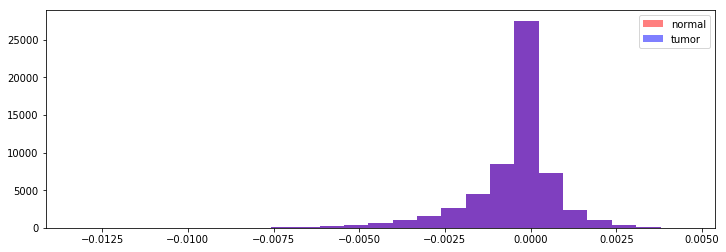

In [31]:
# bins = numpy.linspace(-10, 10, 100)

fig = plt.gcf()
fig.set_size_inches(12,4)
numBins=25
# color=['crimson', 'burlywood', 'chartreuse'],
plt.hist(normalContribution, bins=numBins, alpha=0.5, color=['red'], label='normal')
plt.hist(tumorContribution, bins=numBins, alpha=0.5, color=['blue'], label='tumor')
plt.legend(loc='upper right')

fig = plt.gcf()
size = fig.get_size_inches()*fig.dpi # size in pixels
print("size:{} ".format(size/72)) #pixels / inch = 72
plt.show()

In [19]:
# calculate describtive stats across all the gene average contributions
normalStd = np.std(normalContribution)
normalMean = np.mean(normalContribution)
tumorStd = np.std(tumorContribution)
tumorMean = np.mean(tumorContribution)
print("normalMean:{} , normalStd:{}".format(normalMean , normalStd))
print("tumorMean:{} , tumorStd:{}".format(tumorMean , tumorStd))

normalMean:-0.00048286453752650036 , normalStd:0.0013519555315224447
tumorMean:-0.00048286453752650036 , tumorStd:0.0013519555315224447


In [20]:
# # the mean contribution of all genes is close to zero
# # find genes with highest contribution to Z
# print( "normalTrainDF.loc['mean',:].head():\n{}".format(normalTrainDF.loc["mean",:].head() ))

# print()
# from scipy.stats import zscore

# xxxSeries = normalTrainDF.loc["mean", trainFeatureCols]
# zscores = zscore(xxxSeries)
# s = zscores.shape
# zscores = np.reshape(zscores, (1, s[0]))
# print("type(zscores):{} , zscores.shape:{}, zscores[0:3]:{}".format(type(zscores) , zscores.shape, zscores[0:3]))
# normalZScoreDF = pd.DataFrame(zscores, columns=trainFeatureCols)

# print()
# print( "normalZScoreDF.iloc[0, 0:2]:\n{}".format(normalZScoreDF.iloc[0, 0:2]) )
# print("\nnormalZScoreDF.shape:{}".format(normalZScoreDF.shape) )
# print("\nnormalZScoreDF.iloc[:,0:2].head():\n{}\n".format(normalZScoreDF.iloc[:, 0:2].head()))

In [21]:
# thresholdZScore = 1
# normalInhibitors = normalZScoreDF < -1.0 * thresholdZScore
# print("normalInhibitors.shape{} , normalInhibitors.iloc[0, 0:2]:\n{}"
#       .format(normalInhibitors.shape , normalInhibitors.iloc[0, 0:2]))
# print("number of inhibitors {}".format(normalInhibitors.sum(axis=1)))

# normalPromoters = normalZScoreDF > thresholdZScore
# print("\nnormalPromoters.shape{} , normalPromoters.iloc[0, 0:2]:\n{}"
#       .format(normalPromoters.shape , normalPromoters.iloc[0, 0:2]))
# print("number of promoters {}".format(normalPromoters.sum(axis=1)))

# print("\n test select")
# # yyy = normalZScoreDF.iloc[:, normalPromoters | normalInhibitors]
# # yyy = normalZScoreDF[:, normalPromoters | normalInhibitors]
# replaceFalseValuesWith = np.NaN # this is the default I wanted to be explicit
# # yyy = normalZScoreDF[normalPromoters | normalInhibitors]
# yyy = normalZScoreDF.where(normalPromoters | normalInhibitors, replaceFalseValuesWith)
# print( "yyy.shape:{} ".format(yyy.shape))
# print("yyy[0:2, :]:{}".format(yyy.head()))


# print("\nAEDWIP")
# print(yyy.index)
# print(yyy.columns[0:5])


In [22]:
# maybe it is easier to stick with series
normalMeanSeries = normalTrainDF.loc["mean", trainFeatureCols]

from scipy.stats import zscore
normalZscores = zscore(normalMeanSeries)
# s = normalZscores.shape
# print("s:{} type(zscores):{}".format(s, type(zscores)))
# zscores = np.reshape(zscores, (s[0],1) )
# print("type(zscores):{} , zscores.shape:{}, zscores[0:3]:{}"
#       .format(type(zscores) , zscores.shape, zscores[0:3]))

# print()
# shape = trainFeatureCols.shape
# print("trainFeatureCols shape:{} type(trainFeatureCols):{}".format(shape, type(trainFeatureCols)))

# # rrr =trainFeatureCols.reshape( (1, shape[1]))
# #zScoreSeries = pd.Series(zscores, index=trainFeatureCols.values)
# # print(zScoreSeries.shape)

threshold = 3
# argwhere returns a array of [row, idx] 
normalPromoterIdx = np.argwhere(normalZscores > threshold)
# print(len(promoterIdx))
# print(promoterIdx[0:3])
# print(promoterIdx.shape)
# print(type(promoterIdx))
# print(zscores[7,0])
# print(zscores[8,0])

normalFlatPromoterIdx = normalPromoterIdx.flatten()
# print(flatPromoterIdx.shape)
# print(flatPromoterIdx[0:4])
# print( flatPromoterIdx[flatPromoterIdx > 0][0:4])
geneIdx = normalFlatPromoterIdx[normalFlatPromoterIdx > 0]
print(len(trainFeatureCols[geneIdx]))
print(trainFeatureCols[geneIdx][0:4])

210
Index(['ABCA10', 'ABCA6', 'ABCA8', 'ABCA9'], dtype='object')


In [23]:
tumorMeanSeries = tumorTrainDF.loc["mean", trainFeatureCols]
tumorZScores = zscore(tumorMeanSeries)
# s = tumorZScores.shape
# print("s:{} type(zscores):{}".format(s, type(zscores)))
#zscores = np.reshape(zscores, (s[0],1) )
# print("type(zscores):{} , zscores.shape:{}, zscores[0:3]:{}"
#       .format(type(zscores) , zscores.shape, zscores[0:3]))

# print()
# shape = trainFeatureCols.shape
# print("trainFeatureCols shape:{} type(trainFeatureCols):{}".format(shape, type(trainFeatureCols)))
# # rrr =trainFeatureCols.reshape( (1, shape[1]))
# #zScoreSeries = pd.Series(zscores, index=trainFeatureCols.values)
# # print(zScoreSeries.shape)

# argwhere returns a array of [row, idx] 
tumorPromoterIdx = np.argwhere(tumorZScores > threshold)
# print(len(tumorPromoterIdx))
# print(tumorPromoterIdx[0:3])
# print(tumorPromoterIdx.shape)
# print(type(tumorPromoterIdx))
# print(tumorZScores[7,0])
# print(tumorZScores[8,0])

tumorFlatPromoterIdx = tumorPromoterIdx.flatten()
# print(tumorFlatPromoterIdx.shape)
# print(tumorFlatPromoterIdx[0:4])
# print( tumorFlatPromoterIdx[tumorFlatPromoterIdx > 0][0:4])
geneIdx = tumorFlatPromoterIdx[tumorFlatPromoterIdx > 0]
print(len(trainFeatureCols[geneIdx]))
print(trainFeatureCols[geneIdx][0:4])

273
Index(['AC000089.3', 'AC005255.3', 'AC006386.1', 'AC009065.4'], dtype='object')


In [24]:
# %%time
# from sklearn.metrics import confusion_matrix

# yPredict = model.predict(XTestDF)
# print(type(yPredict))
# print(yPredict[0:3])

# yTestPredict = [1 if p > 0.5 else 0 for p in yPredict]
# #print(yTestPredict[0:3])
# cf = confusion_matrix(yTestDF, yTestPredict)
# print(cf)
# expected = [[1707, 13],[8, 2098]]
# np.testing.assert_array_equal(cf, expected)